## Notebook file carrying out Utah, Alistair single cell RNA sample integration

In [ ]:
!pip install --quiet scvi-tools[tutorials]
!pip install scanpy
!pip install anndata
!pip install --user scikit-misc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.2/380.2 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.1/122.1 kB 8.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.2/330.2 kB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 745.2/745.2 kB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 35.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.5/100.5 kB 13.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 53.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0

In [ ]:
import os
import tempfile
import scvi
import torch
import anndata as ad
import pandas as pd
import scanpy as sc
import numpy as np
import scipy
from scipy.io import mmread

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
sc_raw_data_dir = "/content/drive/MyDrive/single_cell_genomics/"

Mounted at /content/drive


obs column name and anndata field definition

In [ ]:
sample_col = "sample"
barcode_col = "barcode"
source_col = "source"
SCVI_LATENT_KEY = "X_scVI"
SCVI_MDE_KEY = "X_scVI_MDE"

### Load Alistair sc datasets

In [ ]:
alistair_samples = {
    "Y2": "GSM6506105_counts_Y2.txt.gz",
    "Y3": "GSM6506106_counts_Y3.txt.gz",
    "Y5": "GSM6506107_counts_Y5.txt.gz",
    "MJ10": "GSM6506108_counts_MJ10.txt.gz",
    "MJ11": "GSM6506109_counts_MJ11.txt.gz"
}

alistair_anndatas = {}
for abbr, fname in alistair_samples.items():
    df = pd.read_csv(sc_raw_data_dir + fname, sep="\t")
    adata = ad.AnnData(
        X = scipy.sparse.csr_matrix(df.values.T),
        obs = pd.DataFrame(index=df.columns),
        var = pd.DataFrame(index=df.index))
    adata.obs[sample_col] = abbr
    adata.obs[source_col] = "Alistair"
    adata.obs[barcode_col] = adata.obs.index.tolist()
    adata.cell_id = adata.obs[sample_col] + "_" + adata.obs[barcode_col]

    adata.var_names_make_unique()
    alistair_anndatas[abbr] = adata

### Load Utah sc datasets

In [ ]:
utah_sc_abbrs = ["16030X2", "16030X3", "16030X4", "19459X1", "19595X1", "19833X1", "19833X2"]

utah_anndatas = {}
for abbr in utah_sc_abbrs:
  adata = sc.read_10x_mtx(path = sc_raw_data_dir + abbr + "/outs/filtered_feature_bc_matrix/", var_names='gene_symbols', cache=True)

  adata.obs[sample_col] = abbr
  adata.obs[source_col] = "Utah"
  adata.obs[barcode_col] = adata.obs.index.tolist()
  adata.cell_id = adata.obs[sample_col] + "_" + adata.obs[barcode_col]

  features = pd.read_csv(sc_raw_data_dir + abbr + "/outs/filtered_feature_bc_matrix/" + 'features.tsv.gz', sep='\t', header=None, index_col=1)
  features.columns = ['gene_ids', 'feature_types']
  features.index.name = 'gene_symbols'
  adata.var = features

  adata.var_names_make_unique()
  utah_anndatas[abbr] = adata

### Simple QC

In [ ]:
all_anndatas = alistair_anndatas | utah_anndatas

for abbr in all_anndatas.keys():

  adata = all_anndatas[abbr]
  adata.layers['counts'] = adata.X.copy()

  sc.pp.filter_cells(adata, min_genes=200)
  sc.pp.filter_genes(adata, min_cells=3)
  adata.var['mt'] = adata.var_names.str.startswith('MT-')
  sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

  all_anndatas[abbr] = adata

In [ ]:
# n_gene_by_count_thresh = 6000
mt_thresh = 25
all_anndatas_qc = {}
for abbr in all_anndatas.keys():
  adata = all_anndatas[abbr]
  # adata = adata[adata.obs.n_genes_by_counts < n_gene_by_count_thresh, :]
  adata = adata[adata.obs.pct_counts_mt < mt_thresh, :]

  all_anndatas_qc[abbr] = adata

### Inner join all anndata objects

In [ ]:
adata_join = ad.concat(all_anndatas_qc, join="outer")

/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


### Feature selection prior to scVI integration

In [ ]:
qian_markers = pd.read_csv(sc_raw_data_dir + "data/pan_cancer_marker_genes.txt", sep=' ', lineterminator='\r', header = None)
qian_markers = qian_markers.iloc[0,:-1].tolist()
mask = [m in adata_join.var_names for m in qian_markers]
qian_markers_present = [b for a, b in zip(mask, qian_markers) if a]

In [ ]:
sc.pp.highly_variable_genes(
    adata_join,
    flavor="seurat_v3",
    n_top_genes=3000,
    layer="counts",
    batch_key=sample_col,
    subset=False,
)

feature_sel_filter = adata_join.var.index.isin(qian_markers_present) | adata_join.var.highly_variable
sum(feature_sel_filter)

3659

In [ ]:
adata_int = adata_join[:,feature_sel_filter].copy()

/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


### Perform scVI integration

In [ ]:
output_save_dir = '/content/drive/MyDrive/HGSOC_ATLAS/analysis_output/' + 'Utah_Alistair_scVI_integration_full_Utah/'
os.makedirs(output_save_dir, exist_ok=True)

In [ ]:
scvi.model.SCVI.setup_anndata(adata_int, layer="counts", batch_key=sample_col,
                              categorical_covariate_keys = [source_col])
model = scvi.model.SCVI(adata_int, n_layers=2, n_latent=30, gene_likelihood="nb")
model.train()

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 326/326: 100%|██████████| 326/326 [08:34<00:00,  1.55s/it, v_num=1, train_loss_step=914, train_loss_epoch=1.01e+3]

INFO: `Trainer.fit` stopped: `max_epochs=326` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=326` reached.


Epoch 326/326: 100%|██████████| 326/326 [08:34<00:00,  1.58s/it, v_num=1, train_loss_step=914, train_loss_epoch=1.01e+3]


In [ ]:
model.save(output_save_dir + "model", overwrite=True)

In [ ]:
adata_int.obsm[SCVI_LATENT_KEY] = model.get_latent_representation()
sc.pp.neighbors(adata_int, use_rep=SCVI_LATENT_KEY)
sc.tl.leiden(adata_int)
adata_int.obsm[SCVI_MDE_KEY] = scvi.model.utils.mde(adata_int.obsm[SCVI_LATENT_KEY])
denoised = model.get_normalized_expression(adata_int, library_size=1e4)
adata_int.layers["scvi_normalized"] = denoised
adata_int.write(output_save_dir + "integrate.adata", compression = "gzip")

INFO     Using cuda:0 for `pymde.preserve_neighbors`.                                                              


/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/usr/local/lib/python3.10/dist-packages/scanpy/plotting

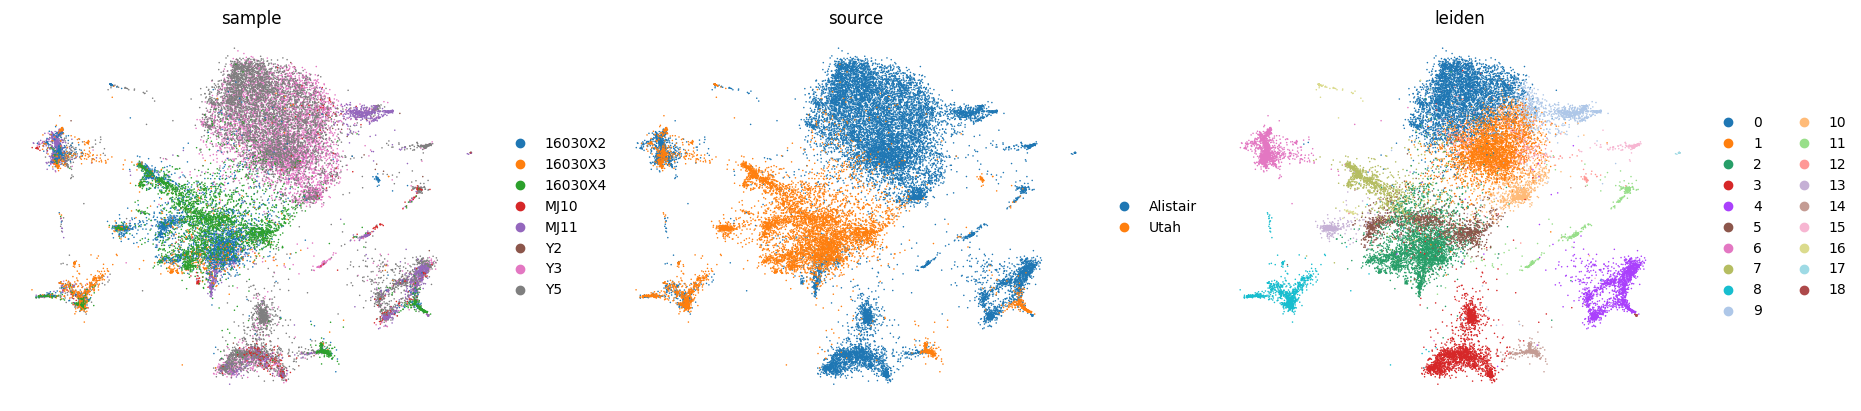

In [ ]:
sc.pl.embedding(
    adata_int,
    basis=SCVI_MDE_KEY,
    color=[sample_col, source_col, "leiden"],
    frameon=False,
    ncols=3,
)

In [ ]:
model = scvi.model.SCVI.load(output_save_dir + "model", adata = adata_int)

INFO     File                                                                                                      
         /content/drive/MyDrive/HGSOC_ATLAS/analysis_output/Utah_Alistair_scVI_integration_full_Utah/model/model.pt
         already downloaded                                                                                        


/usr/local/lib/python3.10/dist-packages/scvi/model/base/_base_model.py:683: UserWarning: var_names for adata passed in does not match var_names of adata used to train the model. For valid results, the vars need to be the same and in the same order as the adata used to train the model.
  _validate_var_names(adata, var_names)


In [ ]:
adata_int.obsm[SCVI_LATENT_KEY] = model.get_latent_representation()
sc.pp.neighbors(adata_int, use_rep=SCVI_LATENT_KEY)
sc.tl.leiden(adata_int)
adata_int.obsm[SCVI_MDE_KEY] = scvi.model.utils.mde(adata_int.obsm[SCVI_LATENT_KEY])
denoised = model.get_normalized_expression(adata_int, library_size=1e4)
adata_int.layers["scvi_normalized"] = denoised

<ipython-input-15-100ff023c845>:3: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_int)


INFO     Using cuda:0 for `pymde.preserve_neighbors`.                                                              


In [ ]:
adata_int.write(output_save_dir + "integrate.adata", compression = "gzip")